In [ ]:
import sys
from pathlib import Path

# Add repo root to sys.path
sys.path.append(str(Path(__file__).resolve().parent.parent.parent))
from src.utils.packages import *
from src.config.config import RAW_DATA_PATH, PROCESSED_DATA_PATH, MODEL_PATH, VAL_RESULTS_PATH, OUTPUT_PATH
from src.utils.utils import preprocess_data, train_and_validate_models, predict_test_data

In [ ]:
train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "train_preprocessed.csv"))

In [5]:
train[:2]

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Item_Weight,Item_Visibility,...,Outlet_Combined_OUT035_Small_Tier_2_Supermarket_Type1,Outlet_Combined_OUT045_Small_Tier_2_Supermarket_Type1,Outlet_Combined_OUT046_Small_Tier_1_Supermarket_Type1,Outlet_Combined_OUT049_Medium_Tier_1_Supermarket_Type1,Item_Combined_Low_Fat_Drinks,Item_Combined_Low_Fat_Food,Item_Combined_Low_Fat_Miscellaneous,Item_Combined_Low_Fat_Non-Consumable,Item_Combined_Regular_Drinks,Item_Combined_Regular_Food
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,Food,9.30,0.016047,...,False,False,False,True,False,True,False,False,False,False
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2,Drinks,5.92,0.019278,...,False,False,False,False,False,False,False,False,True,False


Training LinearRegression...


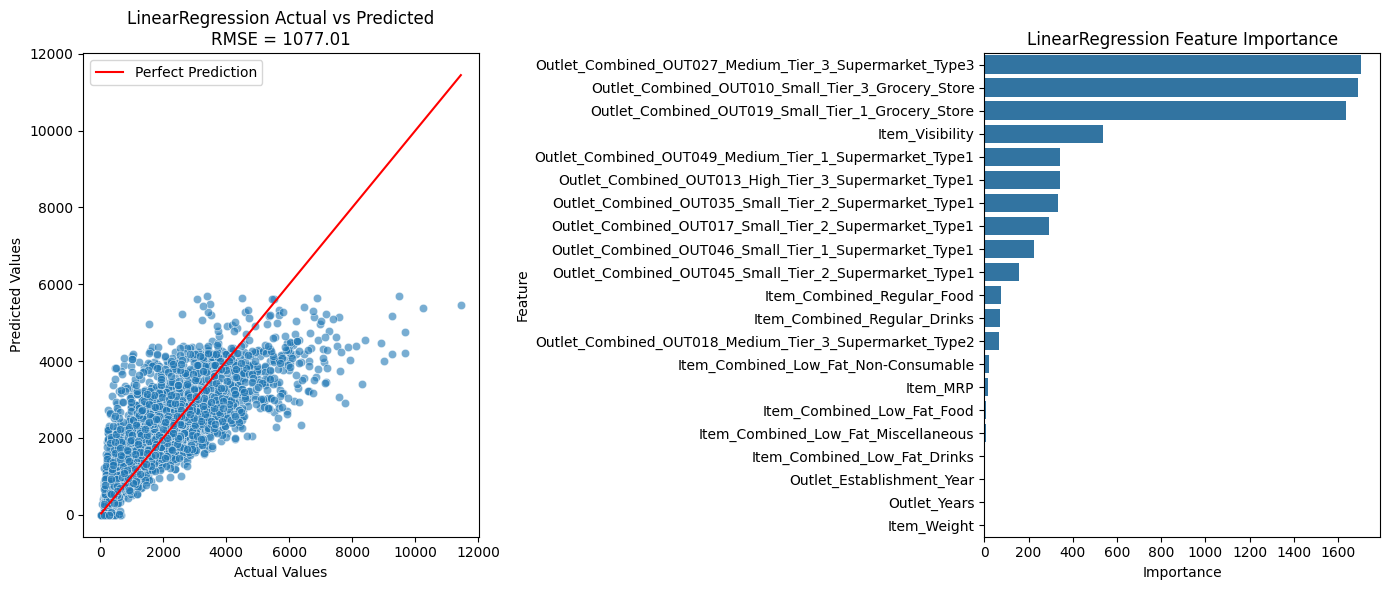

Training Ridge...


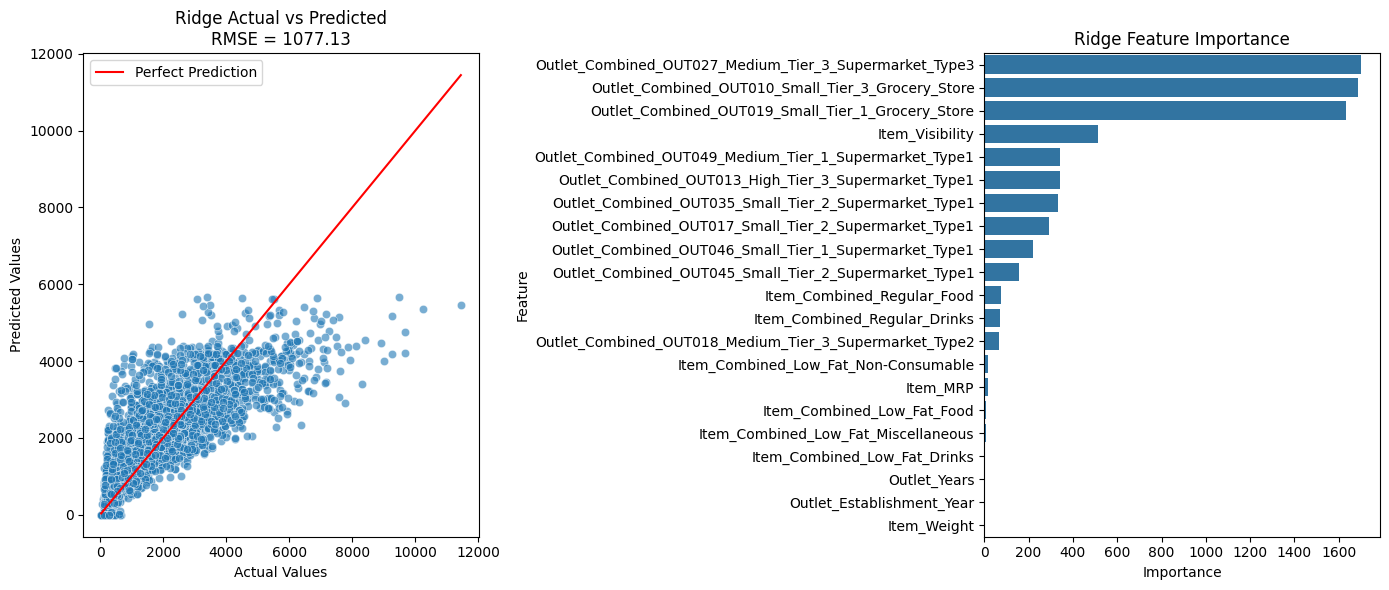

Training Lasso...


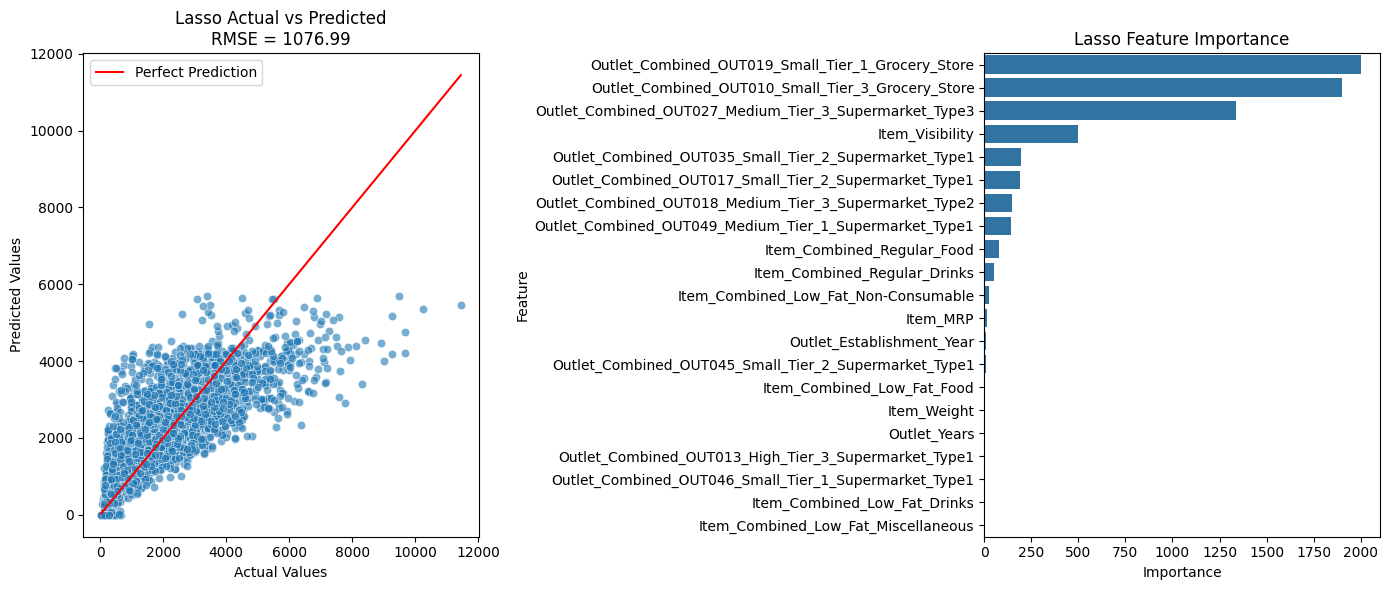

Training RandomForest...


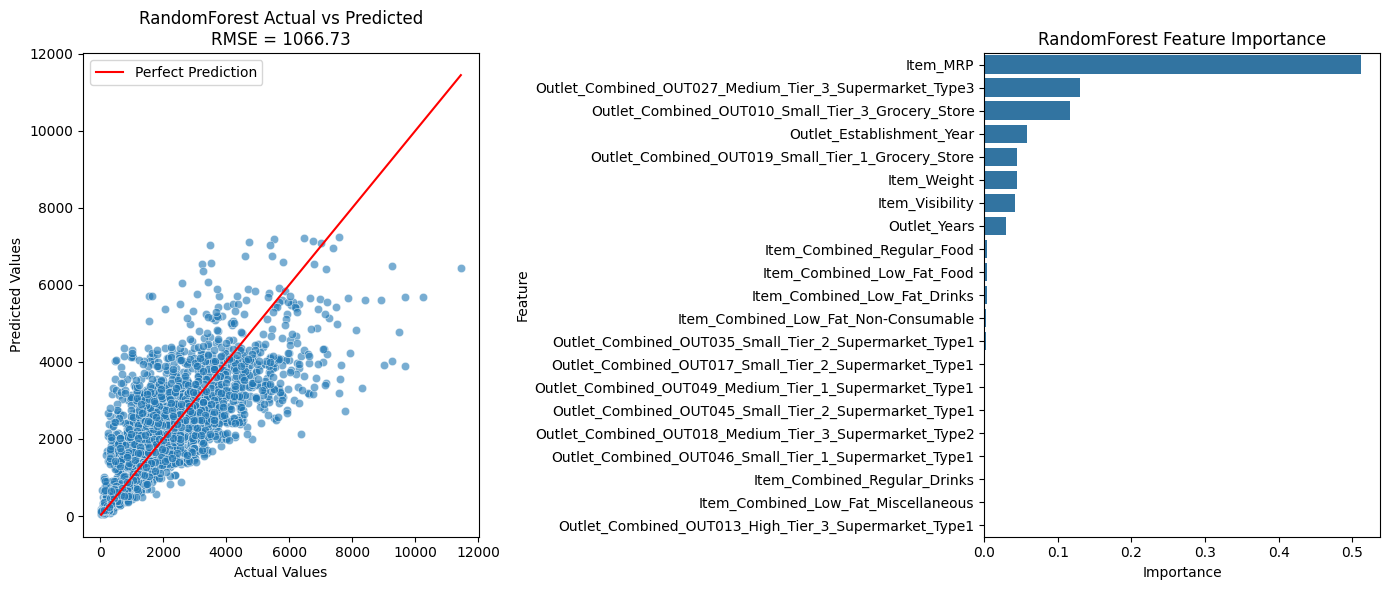

Training GradientBoosting...


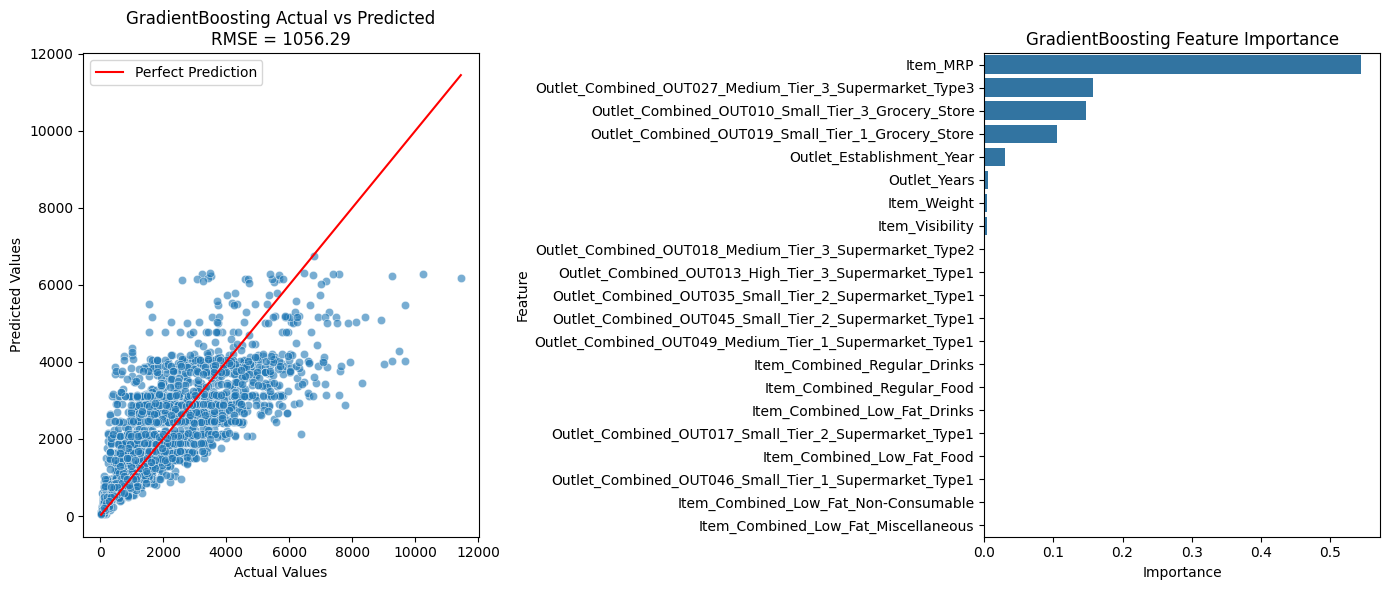

Training SVR...


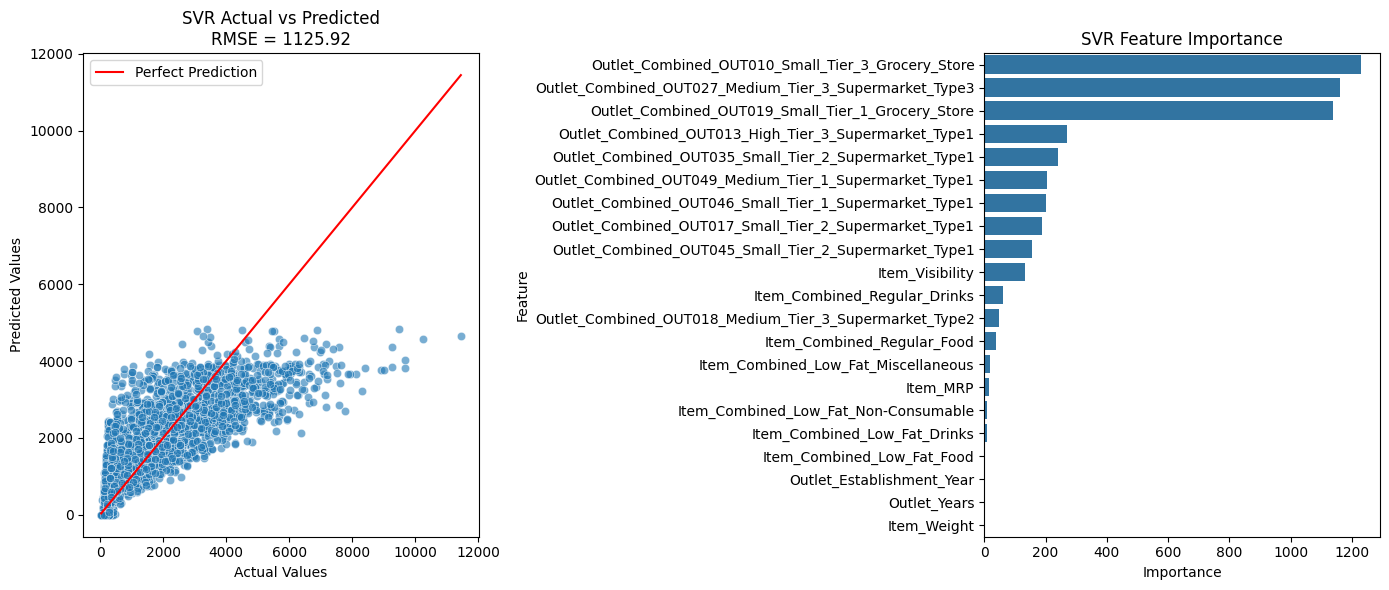

Training XGBRegressor...


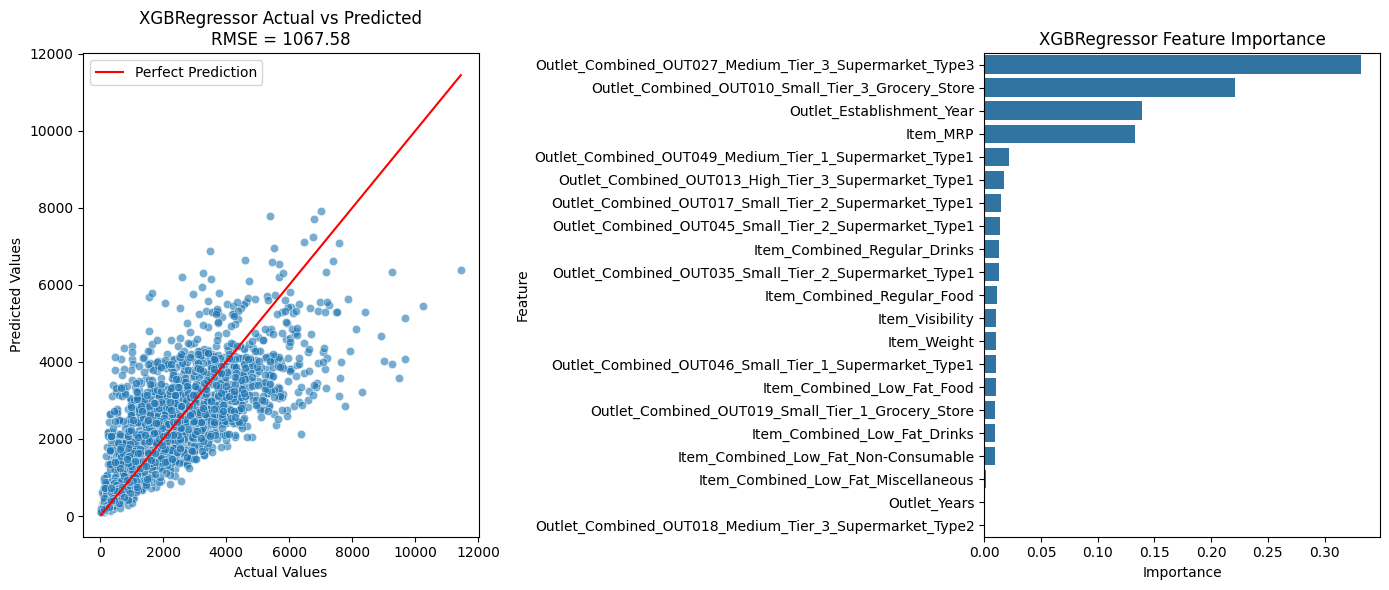

In [6]:
X = train.drop(columns=['Item_Identifier', 'Item_Fat_Content', 
                        'Item_Type', 'Outlet_Identifier',
                        'Outlet_Size', 'Outlet_Location_Type', 
                        'Outlet_Type', 'Item_Category', 'Item_Outlet_Sales'])
y = train['Item_Outlet_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

models_params = {
    "LinearRegression": (LinearRegression(), {"fit_intercept": [True, False]}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1.0, 10]}),
    "Lasso": (Lasso(), {"alpha": [0.001, 0.01, 0.1]}),
    "RandomForest": (RandomForestRegressor(random_state=42), 
                     {"n_estimators": [100, 200], "max_depth": [None, 10]}),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), 
                         {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}),
    "SVR": (SVR(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "XGBRegressor": (XGBRegressor(random_state=42, eval_metric="rmse"), 
                     {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]})
}

def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def calculate_metrics(y_true, y_pred, p):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), p)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    try:
        msle = mean_squared_log_error(y_true, np.maximum(y_pred, 0))
    except:
        msle = np.nan
    return mae, mse, rmse, r2, adj_r2, mape, msle

results = []
train_results = X_train.copy()
train_results['Actual'] = y_train.values
val_results = X_val.copy()
val_results['Actual'] = y_val.values

for name, (model, params) in models_params.items():
    print(f"Training {name}...")
    
    grid = GridSearchCV(model, params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    # Predictions
    y_train_pred = np.clip(best_model.predict(X_train), 0, None)
    y_val_pred = np.clip(best_model.predict(X_val), 0, None)
    
    # Store predictions
    train_results[f"{name}_pred"] = y_train_pred
    val_results[f"{name}_pred"] = y_val_pred
    
    # Compute metrics
    mae, mse, rmse, r2, adj_r2, mape, msle = calculate_metrics(y_val, y_val_pred, X_val.shape[1])
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adj_r2,
        "MAPE": mape,
        "MSLE": msle
    })
    
    # Combined Actual vs Predicted + Feature Importance
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    # Actual vs Predicted
    sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, ax=axes[0])
    sns.lineplot(x=y_val, y=y_val, color='red', label='Perfect Prediction', ax=axes[0])
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")
    axes[0].set_title(f"{name} Actual vs Predicted\nRMSE = {rmse:.2f}")
    
    # Feature Importance
    feature_importances = None
    if hasattr(best_model, "feature_importances_"):
        feature_importances = best_model.feature_importances_
    elif hasattr(best_model, "coef_"):
        feature_importances = np.abs(best_model.coef_)
        if feature_importances.ndim > 1:
            feature_importances = feature_importances.flatten()
    
    if feature_importances is not None:
        fi_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)
        sns.barplot(x="Importance", y="Feature", data=fi_df, ax=axes[1])
        axes[1].set_title(f"{name} Feature Importance")
    else:
        axes[1].text(0.5, 0.5, "No Feature Importance", horizontalalignment='center', verticalalignment='center')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Results dataframe
results_df = pd.DataFrame(results).sort_values(by="RMSE")


In [7]:
results_df

,Model,Best Params,MAE,MSE,RMSE,R2,Adjusted R2,MAPE,MSLE
4,GradientBoosting,"{'learning_rate': 0.05, 'n_estimators': 100}",742.549157,1.115741e+06,1056.286387,0.601662,0.598363,61.846220,0.323634
3,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",743.235415,1.137923e+06,1066.734544,0.593743,0.590378,56.456158,0.294239
6,XGBRegressor,"{'learning_rate': 0.05, 'n_estimators': 100}",742.107342,1.139721e+06,1067.577337,0.593101,0.589730,58.651514,0.306031
2,Lasso,{'alpha': 0.1},772.527161,1.159907e+06,1076.989645,0.585895,0.582464,67.411143,1.797450
0,LinearRegression,{'fit_intercept': True},772.551271,1.159948e+06,1077.009027,0.585880,0.582449,67.389271,1.807224
1,Ridge,{'alpha': 1.0},772.652523,1.160201e+06,1077.126144,0.585790,0.582358,67.440528,1.794675
5,SVR,"{'C': 10, 'kernel': 'linear'}",794.759573,1.267703e+06,1125.923077,0.547410,0.543660,70.256047,1.120836


In [8]:

train_results['Set'] = 'Train'
val_results['Set'] = 'Validation'
all_results = pd.concat([train_results, val_results], ignore_index=True)
cols = ['Set', 'Actual'] + [c for c in all_results.columns if c not in ['Set', 'Actual']]
all_results = all_results[cols]
pred_cols = [c for c in all_results.columns if c.endswith("_pred")]
errors = all_results[pred_cols].sub(all_results['Actual'], axis=0).abs()
all_results['Best_Model_Rowwise'] = errors.idxmin(axis=1)
all_results['Best_Model_Rowwise'] = all_results['Best_Model_Rowwise'].str.replace('_pred', '')

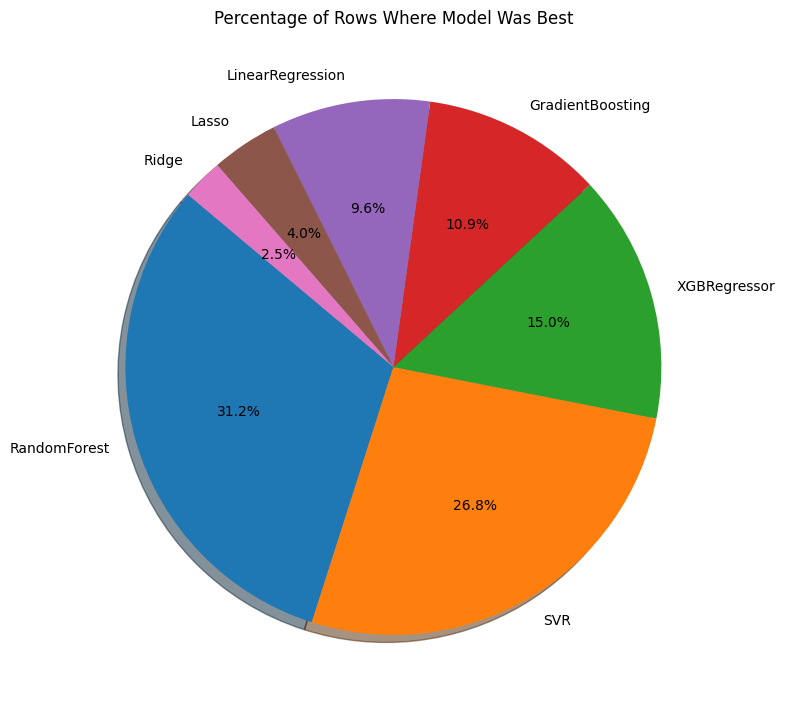

In [9]:

best_model_counts = all_results['Best_Model_Rowwise'].value_counts()
best_model_percent = best_model_counts / best_model_counts.sum() * 100
plt.figure(figsize=(8,8))
plt.pie(best_model_percent, labels=best_model_percent.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title("Percentage of Rows Where Model Was Best")
plt.tight_layout()
plt.show()

In [10]:
top_models = results_df.sort_values('RMSE').head(3)['Model'].tolist()
top_pred_cols = [f"{model}_pred" for model in top_models]
all_results['Top_Combined_pred'] = all_results[top_pred_cols].mean(axis=1)

rmse_top4 = np.sqrt(mean_squared_error(all_results['Actual'], all_results['Top_Combined_pred']))
print(f"RMSE for Top_Combined_pred: {rmse_top4:.2f}")

RMSE for Top_Combined_pred: 1001.64


In [11]:
pred_cols = [c for c in all_results.columns if c.endswith("_pred")]
errors = all_results[pred_cols].sub(all_results['Actual'], axis=0).abs()
all_results['Best_Model_Rowwise'] = errors.idxmin(axis=1)
all_results['Best_Model_Rowwise'] = all_results['Best_Model_Rowwise'].str.replace('_pred', '')

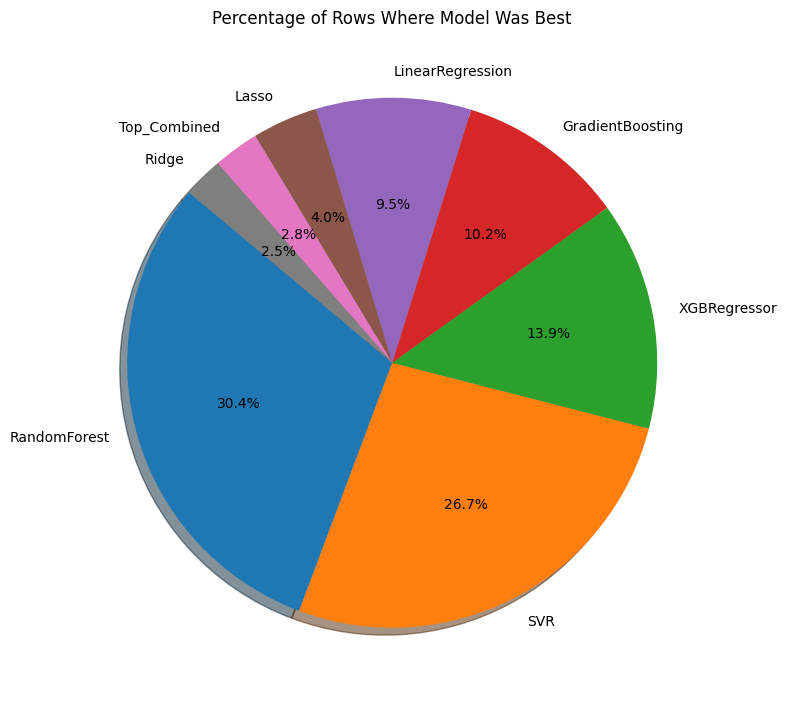

In [12]:
best_model_counts = all_results['Best_Model_Rowwise'].value_counts()
best_model_percent = best_model_counts / best_model_counts.sum() * 100
plt.figure(figsize=(8,8))
plt.pie(best_model_percent, labels=best_model_percent.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title("Percentage of Rows Where Model Was Best")
plt.tight_layout()
plt.show()

In [13]:
all_results[all_results['Set'] == "Validation"].sort_values(by='Actual')

,Set,Actual,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Years,Outlet_Combined_OUT010_Small_Tier_3_Grocery_Store,Outlet_Combined_OUT013_High_Tier_3_Supermarket_Type1,Outlet_Combined_OUT017_Small_Tier_2_Supermarket_Type1,...,Item_Combined_Regular_Food,LinearRegression_pred,Ridge_pred,Lasso_pred,RandomForest_pred,GradientBoosting_pred,SVR_pred,XGBRegressor_pred,Best_Model_Rowwise,Top_Combined_pred
6614,Validation,33.2900,9.105,0.064411,33.3900,1998,15,True,False,False,...,False,0.000000,0.000000,0.000000,75.295636,58.341194,0.000000,129.903229,GradientBoosting,87.846686
8252,Validation,33.9558,11.800,0.134328,35.0558,1985,28,False,False,False,...,True,0.000000,0.000000,0.000000,70.897931,56.594251,0.000000,101.927498,GradientBoosting,76.473227
8483,Validation,34.6216,12.350,0.073077,34.3216,1985,28,False,False,False,...,False,0.000000,0.000000,0.000000,118.054984,56.594251,0.000000,112.936714,GradientBoosting,95.861983
8431,Validation,37.9506,12.150,0.132952,37.6506,1998,15,True,False,False,...,False,0.000000,0.000000,0.000000,113.615238,76.480704,0.000000,173.008163,LinearRegression,121.034702
7771,Validation,37.9506,6.635,0.080698,39.8506,1985,28,False,False,False,...,True,0.000000,0.000000,0.000000,59.220467,74.733761,0.000000,132.412460,RandomForest,88.788896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6927,Validation,9467.6760,8.945,0.087221,263.9910,1985,28,False,False,False,...,True,5681.869303,5679.879488,5681.637170,4765.371863,4280.832100,4844.720451,3579.145264,LinearRegression,4208.449742
7122,Validation,9664.7528,12.600,0.074339,255.5356,2007,6,False,False,True,...,True,4208.794363,4208.507668,4207.911506,3901.349478,4030.151779,3827.840621,4069.798584,LinearRegression,4000.433280
7822,Validation,9678.0688,12.150,0.015386,208.9928,1985,28,False,False,False,...,False,4765.278478,4761.621608,4762.990651,5688.358883,5477.111771,4019.442337,5129.729980,RandomForest,5431.733545
6258,Validation,10236.6750,17.750,0.034584,248.3750,1985,28,False,False,False,...,False,5370.688256,5367.519914,5369.188223,5683.772797,6276.340845,4579.234562,5442.910645,GradientBoosting,5801.008095


In [14]:
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def calculate_metrics(y_true, y_pred, p):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), p)
    return mae, mse, rmse, r2, adj_r2

In [49]:
X = train.drop(columns=['Item_Identifier', 'Item_Fat_Content', 
                        'Item_Type', 'Outlet_Identifier',
                        'Outlet_Size', 'Outlet_Location_Type', 
                        'Outlet_Type', 'Item_Category', 'Item_Outlet_Sales'])
y = train['Item_Outlet_Sales']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Models and hyperparameters
models_params = {
    "LinearRegression": (LinearRegression(), {"fit_intercept": [True, False]}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1.0, 10]}),
    "Lasso": (Lasso(), {"alpha": [0.001, 0.01, 0.1]}),
    "RandomForest": (RandomForestRegressor(random_state=42), 
                     {"n_estimators": [100, 200], "max_depth": [None, 10]}),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), 
                         {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}),
    "SVR": (SVR(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "XGBRegressor": (XGBRegressor(random_state=42, eval_metric="rmse"), 
                     {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]})
}

# Metric functions
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def calculate_metrics(y_true, y_pred, p):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), p)
    return mae, mse, rmse, r2, adj_r2

# Prepare results containers
results = []
train_results = X_train.copy()
train_results['Actual'] = y_train.values
val_results = X_val.copy()
val_results['Actual'] = y_val.values
os.makedirs(model_path, exist_ok=True)

best_models = {}

# Baseline (predict mean of training target)
baseline_pred = np.full_like(y_val, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_pred))

# Training + validation loop
for name, (model, params) in models_params.items():
    print(f"\nTraining {name}...")
    
    # Grid search for hyperparameters
    grid = GridSearchCV(model, params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    # Save model
    model_filename = os.path.join(model_path, f"{name}_best_model.joblib")
    joblib.dump(best_model, model_filename)
    print(f"Saved {name} best model to {model_filename}")
    
    # Predictions
    y_train_pred = np.clip(best_model.predict(X_train), 0, None)
    y_val_pred = np.clip(best_model.predict(X_val), 0, None)
    
    # Store predictions
    train_results[f"{name}_pred"] = y_train_pred
    val_results[f"{name}_pred"] = y_val_pred
    
    # Compute metrics
    mae, mse, rmse, r2, adj_r2 = calculate_metrics(y_val, y_val_pred, X_val.shape[1])
    rel_error_pct = 100 * (rmse / y_val.mean())  # Relative RMSE %
    
    # Cross-validation RMSE
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    cv_rmse_scores = -cv_scores  # convert to positive RMSE
    mean_cv_rmse = cv_rmse_scores.mean()
    std_cv_rmse = cv_rmse_scores.std()
    min_cv_rmse = cv_rmse_scores.min()
    max_cv_rmse = cv_rmse_scores.max()
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adj_r2,
        "Min Y_Val": y_val.min(),
        "Max Y_Val": y_val.max(),
        "Mean Y_Val": y_val.mean(),
        "Baseline RMSE": baseline_rmse,
        "Relative Error (%)": rel_error_pct,
        "CV RMSE Mean": mean_cv_rmse,
        "CV RMSE Std": std_cv_rmse,
        "CV RMSE Min": min_cv_rmse,
        "CV RMSE Max": max_cv_rmse,
        "Model Path": model_filename
    })

# Save validation results
results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_csv_path = os.path.join(val_results_path, "model_validation_results.csv")
os.makedirs(val_results_path, exist_ok=True)
results_df.to_csv(results_csv_path, index=False)
print(f"Saved validation results to {results_csv_path}")

# Top model
top_model_row = results_df.loc[results_df['RMSE'].idxmin()]
top_model_path = top_model_row['Model Path']
top_model_name = top_model_row['Model']
best_model = joblib.load(top_model_path)
print(f"\nTop model: {top_model_name} | Loaded from: {top_model_path}")


Training LinearRegression...
Saved LinearRegression best model to ..\..\Data\Models\LinearRegression_best_model.joblib

Training Ridge...
Saved Ridge best model to ..\..\Data\Models\Ridge_best_model.joblib

Training Lasso...
Saved Lasso best model to ..\..\Data\Models\Lasso_best_model.joblib

Training RandomForest...
Saved RandomForest best model to ..\..\Data\Models\RandomForest_best_model.joblib

Training GradientBoosting...
Saved GradientBoosting best model to ..\..\Data\Models\GradientBoosting_best_model.joblib

Training SVR...
Saved SVR best model to ..\..\Data\Models\SVR_best_model.joblib

Training XGBRegressor...
Saved XGBRegressor best model to ..\..\Data\Models\XGBRegressor_best_model.joblib
Saved validation results to ..\..\Data\Validation_Results\model_validation_results.csv

Top model: GradientBoosting | Loaded from: ..\..\Data\Models\GradientBoosting_best_model.joblib


In [ ]:
results_csv_path = os.path.join(VAL_RESULTS_PATH, "model_validation_results.csv")
results_df = pd.read_csv(results_csv_path)

In [51]:
results_df

,Model,Best Params,MAE,MSE,RMSE,R2,Adjusted R2,Min Y_Val,Max Y_Val,Mean Y_Val,Baseline RMSE,Relative Error (%),CV RMSE Mean,CV RMSE Std,CV RMSE Min,CV RMSE Max,Model Path
0,GradientBoosting,"{'learning_rate': 0.05, 'n_estimators': 100}",742.549157,1.115741e+06,1056.286387,0.601662,0.598363,33.29,11445.102,2126.240242,1675.463558,49.678600,1096.851285,33.307971,1054.118696,1136.439715,..\..\Data\Models\GradientBoosting_best_model....
1,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",743.235415,1.137923e+06,1066.734544,0.593743,0.590378,33.29,11445.102,2126.240242,1675.463558,50.169991,1115.660036,31.786040,1071.517090,1154.898402,..\..\Data\Models\RandomForest_best_model.joblib
2,XGBRegressor,"{'learning_rate': 0.05, 'n_estimators': 100}",742.107342,1.139721e+06,1067.577337,0.593101,0.589730,33.29,11445.102,2126.240242,1675.463558,50.209629,1116.212290,31.850595,1073.448275,1153.934467,..\..\Data\Models\XGBRegressor_best_model.joblib
3,Lasso,{'alpha': 0.1},772.527161,1.159907e+06,1076.989645,0.585895,0.582464,33.29,11445.102,2126.240242,1675.463558,50.652303,1144.455713,26.441069,1103.308045,1174.647871,..\..\Data\Models\Lasso_best_model.joblib
4,LinearRegression,{'fit_intercept': True},772.551271,1.159948e+06,1077.009027,0.585880,0.582449,33.29,11445.102,2126.240242,1675.463558,50.653214,1144.538726,26.421129,1103.394648,1174.739444,..\..\Data\Models\LinearRegression_best_model....
5,Ridge,{'alpha': 1.0},772.652523,1.160201e+06,1077.126144,0.585790,0.582358,33.29,11445.102,2126.240242,1675.463558,50.658723,1144.500715,26.440716,1103.341327,1174.744516,..\..\Data\Models\Ridge_best_model.joblib
6,SVR,"{'C': 10, 'kernel': 'linear'}",794.759573,1.267703e+06,1125.923077,0.547410,0.543660,33.29,11445.102,2126.240242,1675.463558,52.953709,1191.644856,25.628844,1154.890784,1223.110054,..\..\Data\Models\SVR_best_model.joblib


In [ ]:
test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "test_preprocessed.csv"))
test_df = test.copy()
drop_cols = [col for col in test_df.columns if '_Combined' in col]
test_df.drop(columns=drop_cols, inplace=True)

In [ ]:
n = 3  
top_n_model_paths = results_df.sort_values(by="RMSE").head(n)['Model Path'].tolist()
print(f"Top {n} model paths:", top_n_model_paths)

X_test = test.drop(columns=['Item_Identifier', 'Item_Fat_Content', 
                        'Item_Type', 'Outlet_Identifier',
                        'Outlet_Size', 'Outlet_Location_Type', 
                        'Outlet_Type', 'Item_Category'])
for model_path in top_n_model_paths:
    model_name = os.path.splitext(os.path.basename(model_path))[0].replace("_best_model", "")
    model = joblib.load(model_path)
    y_pred = np.clip(model.predict(X_test), 0, None)
    test_df[model_name + "_pred"] = y_pred
top_pred_cols = [col for col in test_df.columns if '_pred' in col]
test_df['Item_Outlet_Sales'] = test_df[top_pred_cols].mean(axis=1)
out_put_csv_path = os.path.join(OUTPUT_PATH, "test.csv")
os.makedirs(OUTPUT_PATH, exist_ok=True)
test_df[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv(
    out_put_csv_path,
    index=False,
    float_format="%.4f"  
)
print(f"Saved test output to {out_put_csv_path}")

Top 3 model paths: ['..\\..\\Data\\Models\\GradientBoosting_best_model.joblib', '..\\..\\Data\\Models\\RandomForest_best_model.joblib', '..\\..\\Data\\Models\\XGBRegressor_best_model.joblib']
Saved test output to ..\..\Data\Output_Data\test.csv


In [37]:
test_df[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].sort_values(by='Item_Outlet_Sales')

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
4409,FDG59,OUT019,71.493293
2751,FDT04,OUT019,72.620941
474,FDV28,OUT019,73.315778
3231,FDX10,OUT019,74.345551
3060,NCY41,OUT019,75.473123
...,...,...,...
284,FDG28,OUT027,6910.728691
2634,NCZ42,OUT027,6933.769370
4086,FDI09,OUT027,7048.602979
1453,FDK21,OUT027,7303.816035
